# Regresión lineal para predecir salarios en USD


En el presente documento se utilizará Python para implementar un modelo de regresión lineal en un conjunto de datos acerca de salarios.

De modo que la dinámica del documento involucra código en Python, junto a explicaciones y análisis entre el código.

### Contenidos:

- [Dataframe original](#Dataframe-original)
- [Limpiado de dataframe](#Limpiado-de-dataframe)
  - [Eliminar columnas innecesarias](#Eliminar-columnas-innecesarias)
  - [Verificar que hay mas filas que columnas](#Verificar-que-hay-mas-filas-que-columnas)
  - [Verificar que no haya datos nulos](#Verificar-que-no-haya-datos-nulos)
  - [Verificar datos numericos](#Verificar-datos-numericos)
- [Resolver variables categoricas](#Resolver-variables-categoricas)
  - [_experience_level_](#experience_level)
  - [_employment_type_](#employment_type)
  - [Añadir variables dicotómicas a nuestro dataframe](#Anadir-variables-dicotomicas-a-nuestro-dataframe)
- [Correlacion de las variables regresoras](#Correlacion-de-las-variables-regresoras)
  - [Determinar alta y baja correlación](#Determinar-alta-y-baja-correlacion)
  - [Estandarizar datos](#Estandarizar-datos)
- [Dividir base de datos entre prueba y entrenamiento](#Dividir-base-de-datos-entre-prueba-y-entrenamiento)
- [Implementar modelo de regresion linear](#Implementar-modelo-de-regresion-linear)
  - [Preparar formula](#Preparar-formula)
  - [Formula resultante](#Formula-resultante)
  - [Ejecución del modelo](#Ejecucion-del-modelo)
  - [Interpretación](#Interpretacion)
- [Comprobar modelo](#Comprobar-modelo)
  - [Extraer coeficientes resultantes según hipótesis nula](#Extraer-coeficientes-resultantes-tomando-en-cuenta-la-hipotesis-nula)
  - [Ecuación resultante](#Ecuacion-resultante)
  - [Segunda iteración](#Segunda-iteracion-del-modelo)
  - [Tercera iteración](#Tercera-iteracion-del-modelo)
  - [Comprobación de mejor iteración](#Comprobación-de-mejor-iteracion)
  - [Aproximar valores de $y$ usando modelo](#Aproximar-valores-de-y-usando-modelo)
- [Análisis de errores](#Analisis-de-errores)
  - [QQ-plot y prueba Kolmogorov-Smirnov (K-S test)](#QQ-plot-y-prueba-Kolmogorov-Smirnov-(K-S-test))
  - [Estandarización de errores y K-S test](#Estandarizacion-de-errores-y-K-S-test)
  - [QQ-plot](#QQ-plot)
  - [Histograma de residuos](#Histograma-de-residuos)
- [Resultados finales](#Resultados-finales)
  - [Ecuación final](#Ecuacion-final)
- [Conclusión](#Conclusion)

_Algunos encabezados carecen de tildes (ej.: 'á') o de letras 'ñ' por problemas de compatibilidad_


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from IPython.display import display, Math
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

#### Dataframe original


In [2]:
df = pd.read_csv("./ds_salaries.csv")
df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Limpiado de dataframe

### Eliminar columnas innecesarias


In [3]:
columns_to_keep = set(
    ["salary", "remote_ratio", "experience_level", "employment_type", "salary_in_usd"]
)

for col in df.columns:
    if col not in columns_to_keep:
        df = df.drop([col], axis=1)

df.head()

,experience_level,employment_type,salary,salary_in_usd,remote_ratio
0,MI,FT,70000,79833,0
1,SE,FT,260000,260000,0
2,SE,FT,85000,109024,50
3,MI,FT,20000,20000,0
4,SE,FT,150000,150000,50


### Verificar que hay mas filas que columnas

Requisito para que la matríz pueda ser invertida, parte del algoritmo de regresión


In [4]:
df.shape

(607, 5)

### Verificar que no haya datos nulos


In [5]:
df.isnull().sum()

experience_level    0
employment_type     0
salary              0
salary_in_usd       0
remote_ratio        0
dtype: int64

### Verificar datos numericos

Es decir, que los datos numéricos sean variables numéricas y no strings o algún otro tipo de dato.

Cabe mencionar, que hay datos que se esperan que no sean numéricos de momento, este caso: _experience_level_, _employment_type_


In [6]:
df.dtypes

experience_level    object
employment_type     object
salary               int64
salary_in_usd        int64
remote_ratio         int64
dtype: object

In [7]:
df.head()

,experience_level,employment_type,salary,salary_in_usd,remote_ratio
0,MI,FT,70000,79833,0
1,SE,FT,260000,260000,0
2,SE,FT,85000,109024,50
3,MI,FT,20000,20000,0
4,SE,FT,150000,150000,50


### Limpieza terminada

Resultado:


In [8]:
df.head()

,experience_level,employment_type,salary,salary_in_usd,remote_ratio
0,MI,FT,70000,79833,0
1,SE,FT,260000,260000,0
2,SE,FT,85000,109024,50
3,MI,FT,20000,20000,0
4,SE,FT,150000,150000,50


## Resolver variables categoricas

_employment_type_ y _experience_level_ son variables categóricas detonadas por una cadena de texto, es necesario que estas sean representadas por cadenas de texto.

Si bien hay una jerarquía clara en una de las categorías (_experience_level_), no es posible inferir un valor numérico para cada nivel, por lo que ambas serán representadas de manera dicotonómica.

#### _experience_level_


In [9]:
dummies_experience_level = pd.get_dummies(df["experience_level"], "experience_level")
dummies_experience_level.head()

,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,False,False,True,False
1,False,False,False,True
2,False,False,False,True
3,False,False,True,False
4,False,False,False,True


#### _employment_type_

In [10]:
dummies_employment_type = pd.get_dummies(df["employment_type"], "employment_type")
dummies_employment_type.head()

,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False


### Anadir variables dicotomicas a nuestro dataframe

Y eliminar las columnas originales de dichas variables


In [11]:
df.head()  # To compare

,experience_level,employment_type,salary,salary_in_usd,remote_ratio
0,MI,FT,70000,79833,0
1,SE,FT,260000,260000,0
2,SE,FT,85000,109024,50
3,MI,FT,20000,20000,0
4,SE,FT,150000,150000,50


In [12]:
df = df.drop(["employment_type", "experience_level"], axis=1)
df = pd.concat([df, dummies_employment_type, dummies_experience_level], axis=1)
df.head()

,salary,salary_in_usd,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,70000,79833,0,False,False,True,False,False,False,True,False
1,260000,260000,0,False,False,True,False,False,False,False,True
2,85000,109024,50,False,False,True,False,False,False,False,True
3,20000,20000,0,False,False,True,False,False,False,True,False
4,150000,150000,50,False,False,True,False,False,False,False,True


## Correlacion de las variables regresoras

El algoritmo de regresión invierte la matriz, por lo que es necesario que las variables sean independientes.

Para ello calcularemos la correlación entre ellas y comprobaremos que no se encuentren en el siguiente intervalo:

$$[-1, -0.95] \cup [0.95, 1]$$

In [13]:
correlacion = df.corr()
correlacion.head()

,salary,salary_in_usd,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
salary,1.000000,-0.083906,-0.014608,-0.008268,-0.014568,0.025685,-0.020006,-0.015845,0.014130,0.074626,-0.065995
salary_in_usd,-0.083906,1.000000,0.132122,0.092907,-0.073863,0.091819,-0.144627,-0.294196,0.259866,-0.252024,0.343513
remote_ratio,-0.014608,0.132122,1.000000,0.065149,-0.016865,-0.023834,-0.002935,-0.010490,0.041208,-0.127850,0.113071
employment_type_CT,-0.008268,0.092907,0.065149,1.000000,-0.007423,-0.506989,-0.011795,0.066013,0.070739,-0.028817,-0.047768
employment_type_FL,-0.014568,-0.073863,-0.016865,-0.007423,1.000000,-0.453089,-0.010541,-0.033537,-0.017229,0.068108,-0.034520


### Determinar alta y baja correlacion


En este caso las variables no están correlacionadas. Por lo que no hará falta de momento estandarizar los datos

In [14]:
alta_corr = np.where((correlacion > 0.95) & correlacion < 1)
alta_corr

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10], dtype=int64),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  2,  3,  4,  5,  6,  7,
         8,  9, 10,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  4,
         5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  5,  6,  7,  8,  9, 10,  0,
         1,  2,  3,  4,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  7,  8,
         9, 10,  0,  1,  2,  3,  4,  5,  6,  8,  9, 10,  0,  1,  2,  3,  4,
         5,  6,  7,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8, 10,  0,  1,
         2,  3,  4,  5,  6,  7,  

In [15]:
baja_corr = np.where((correlacion < -0.95) & (correlacion > -1))
baja_corr

(array([], dtype=int64), array([], dtype=int64))

En este caso, hay datos que están correlacionados en el extremo positivo, por lo que estandarizaremos la totalidad del dataframe

### Estandarizar datos

In [16]:
scaler = StandardScaler()
df_estandar = scaler.fit_transform(df)
df_estandar = pd.DataFrame(df_estandar, columns=df.columns)
df_estandar.head()

,salary,salary_in_usd,remote_ratio,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE
0,-0.164605,-0.457904,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
1,-0.041475,2.083282,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
2,-0.154885,-0.046177,-0.514377,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674
3,-0.197008,-1.301826,-1.743615,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,1.360061,-0.925348
4,-0.112761,0.531774,-0.514377,-0.091135,-0.081446,0.179758,-0.129423,-0.411773,-0.211543,-0.735261,1.080674


### Dividir base de datos entre prueba y entrenamiento

In [17]:
train_df, test_df = train_test_split(df_estandar, test_size=0.2, random_state=42)
print("Training items:", train_df["salary"].count())

Training items: 485


In [18]:
print("Testing items:", test_df["salary"].count())

Testing items: 122


## Implementar modelo de regresion linear


### Preparar formula

Nuestro modelo de regresión viene de la librería _Statsmodels_, la cual toma un dataframe, y una formula con las variables de la siguiente forma:

**VariableDeRespuesta~VariableRegresora+...+VariableRegresora**

A continuación se presenta un algoritmo sencillo para generar dicha formula

In [19]:
train_df.columns

Index(['salary', 'salary_in_usd', 'remote_ratio', 'employment_type_CT',
       'employment_type_FL', 'employment_type_FT', 'employment_type_PT',
       'experience_level_EN', 'experience_level_EX', 'experience_level_MI',
       'experience_level_SE'],
      dtype='object')

Es necesario omitir algunas columnas de las variables dicotómicas para evitar redundancia

In [20]:
train_df.columns
columns_to_skip = set(["employment_type_PT", "experience_level_SE"])
y_columns = "salary_in_usd"

In [21]:
cols = train_df.columns
formula_string = y_columns + "~"
for col in cols:
    if (col in columns_to_skip) or (col == y_columns) :
        continue
    if col != cols[0]:
        formula_string += "+"
    formula_string += col

#### Formula resultante

In [22]:
first_iteration_formula = formula_string
print(formula_string)

salary_in_usd~salary+remote_ratio+employment_type_CT+employment_type_FL+employment_type_FT+experience_level_EN+experience_level_EX+experience_level_MI


### Ejecucion del modelo

In [23]:
modelo = smf.ols(formula=formula_string, data=train_df)
modelo = modelo.fit()
first_iteration_model = modelo
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     21.37
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           8.41e-28
Time:                        21:35:35   Log-Likelihood:                -627.06
No. Observations:                 485   AIC:                             1272.
Df Residuals:                     476   BIC:                             1310.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0167    

### Interpretacion

El primer valor a analizar del modelo, es $R^2$, pues este es el coeficiente que nos indica qué tan bien se ajustan los coeficientes de las variables independientes al resultado de la variable dependiente.

Entre $R^2$ más se acerque a 1, mejor es el modelo.

Como se puede observar, en nuestro modelo resultante $R^2 = 0.264$, algo bastante bajo.

Esto se puede deber a muchas cosas. Una de ellas es que los datos de entrenamiento hayan sido insuficientes, o la muestra aleatoria de entrenamiento del total (80%) no haya sido la mejor. Es por ello que existen **métodos de validación cruzada** que intercalan diferentes partes de la muestra para entrenar el modelo, como _K-fold_.

Incluso esto pueda que se deba a que nuestros datos no tengan en realidad una distribución lineal.

La razón en la que se profundizará en la siguiente sección, es la prescencia de variables regresoras cuyo coeficiente final deba de ser removido debido a que se cumple la **hipótesis nula**.



## Comprobar modelo

### Extraer coeficientes resultantes tomando en cuenta la hipotesis nula

Una vez adquiridos los resultados del modelo, será necesario extraer los coeficientes que resulten pertinentes.

Para ello en el siguiente algoritmo simplemente se recorren todos los valores y en caso de que el p-valor sea mayor a 0.05, se omite dicho coeficiente en la ecuación final.

Esto se debe a que en dicho caso, se estaría aprobando la hipotésis nula, que establece que el coeficiente en cuestión es igual a 0.

In [24]:
def extractCoeficientes(model):
  cols = model.params.index
  coefs = model.params.values
  pvalues = model.pvalues.values

  new_coefs = []
  y_approx_formula = "y ="

  coef_count = 1
  for (col, coef, pvalue) in zip(cols, coefs, pvalues):
      
      #Skip p-values greater than 0.5
      if pvalue > 0.05: 
        continue
      new_coefs.append((col, coef))
      y_approx_formula += "+" if coef > 0 else ""
      y_approx_formula += f"{round(coef, 4)}x_{coef_count}"
      coef_count += 1

  display(Math(y_approx_formula))

  return new_coefs


### Ecuacion resultante

In [25]:
new_coefs = extractCoeficientes(modelo)

<IPython.core.display.Math object>

Antes de hacer comprobaciones más a fondo del modelo, será necesario optimizarlo de manera simple.

Tomando en cuenta que hubo variables (columnas de nuestro dataframe) que han sido eliminadas por la hipótesis nula, a continuación se harán nuevas iteraciones del modelo omitiendo dichas variables en la fórmula.

### Segunda iteracion del modelo

In [26]:
cols = new_coefs = [coef[0] for coef in new_coefs]

print("Old: ", formula_string)

formula_string = y_columns + "~"
for col in cols:
    if (col in columns_to_skip) or (col == y_columns) :
        continue
    if col != cols[0]:
        formula_string += "+"
    formula_string += col
  
print("New: ", formula_string)


Old:  salary_in_usd~salary+remote_ratio+employment_type_CT+employment_type_FL+employment_type_FT+experience_level_EN+experience_level_EX+experience_level_MI
New:  salary_in_usd~salary+employment_type_CT+experience_level_EN+experience_level_EX+experience_level_MI


In [27]:
modelo = smf.ols(formula=formula_string, data=train_df)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     33.04
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           5.65e-29
Time:                        21:35:35   Log-Likelihood:                -629.63
No. Observations:                 485   AIC:                             1271.
Df Residuals:                     479   BIC:                             1296.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0179    

Como se presenta en el resultado, $R^2$ es ligeramente aún más baja. No obstante, hay una columna más, cuyo p-valor aprueba la hipótesis nula. Por lo tanto se hará una tercera iteración para ver si mejora.

In [28]:
new_coefs = extractCoeficientes(modelo)

cols = new_coefs = [coef[0] for coef in new_coefs]

print("Old: ", formula_string)

formula_string = y_columns + "~"
for col in cols:
    if (col in columns_to_skip) or (col == y_columns) :
        continue
    if col != cols[0]:
        formula_string += "+"
    formula_string += col
  
print("New: ", formula_string)

<IPython.core.display.Math object>

Old:  salary_in_usd~salary+employment_type_CT+experience_level_EN+experience_level_EX+experience_level_MI
New:  salary_in_usd~salary+experience_level_EN+experience_level_EX+experience_level_MI


### Tercera iteracion del modelo

In [29]:
modelo = smf.ols(formula=formula_string, data=train_df)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     40.70
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           2.24e-29
Time:                        21:35:35   Log-Likelihood:                -630.66
No. Observations:                 485   AIC:                             1271.
Df Residuals:                     480   BIC:                             1292.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0178    

Para esta tercera iteración, vemos que $R^2$ es aún menor.

Al no haber coeficientes cuyo p-valor comprueba la hipótesis nula (sin tomar en cuenta el intercepto, $\beta_0$), tomaremos la iteración con mejores resultados. La cual fue la primera.

### Comprobación de mejor iteracion

In [30]:
print(first_iteration_model.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     21.37
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           8.41e-28
Time:                        21:35:35   Log-Likelihood:                -627.06
No. Observations:                 485   AIC:                             1272.
Df Residuals:                     476   BIC:                             1310.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0167    

In [31]:
new_coefs = extractCoeficientes(first_iteration_model)
print(new_coefs)

<IPython.core.display.Math object>

[('salary', -0.14548299749333402), ('employment_type_CT', 0.09801437216871596), ('experience_level_EN', -0.3717055714757485), ('experience_level_EX', 0.19024835708034454), ('experience_level_MI', -0.3224556967707892)]


### Aproximar valores de $y$ usando modelo

In [32]:
b1x1 = -0.14548299749333402 * test_df["salary"]
b2x2 = 0.09801437216871596 * test_df["employment_type_CT"]
b3x3 = -0.3717055714757485 * test_df["experience_level_EN"]
b4x4 = 0.19024835708034454 * test_df["experience_level_EX"]
b5x5 = -0.3224556967707892 * test_df["experience_level_MI"]

y_aprox = b1x1 + b2x2 + b3x3 + b4x4 + b5x5

Text(0, 0.5, 'Predicción del modelo')

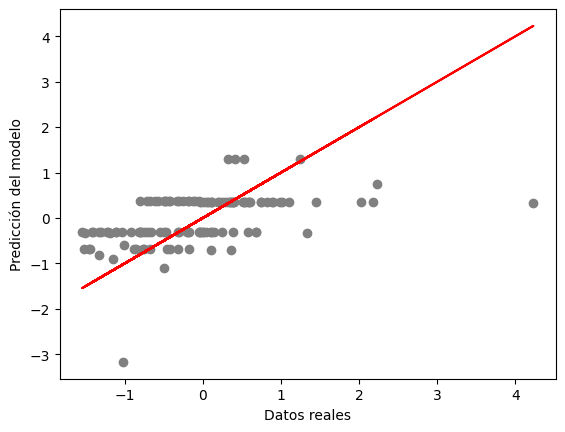

In [33]:
plt.scatter(test_df["salary_in_usd"], y_aprox, color="gray")
plt.plot(test_df["salary_in_usd"], test_df["salary_in_usd"], color="red")
plt.xlabel("Datos reales")
plt.ylabel("Predicción del modelo")

Esta es probablemente la gráfica más importante para interpretar nuestros resultados de manera visual.

Si bien vemos que el modelo tiene carencias, en el peculiar ordenamiento de los datos se ve una ligera tendencia en como los cúmulos en formas de líneas se van hacia las $x$ y $y$ positivas y  según la pendiente de la recta.

## Analisis de errores

Luego de una interpretación meramente visual, es pertinente usar métricas para juzgar los errores.

Para ello primero será necesario calcular los errores através de la diferencia de los valores reales de prueba y los valores predichos con el modelo.

In [34]:
comparison_data = {
    "real": test_df["salary_in_usd"],
    "prediction": y_aprox,
    "errors": test_df["salary_in_usd"] - y_aprox,
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df.head()

,real,prediction,errors
563,0.394254,0.358293,0.035961
289,0.320205,0.358788,-0.038583
76,-0.173457,-0.313561,0.140104
78,2.224328,0.754826,1.469502
182,-1.217128,-0.306207,-0.910921


### QQ-plot y prueba Kolmogorov-Smirnov (K-S test)

Un primer análisis es comparar los residuos a una distribución normal, puesto que de haber hecho un modelo aceptable, los errores deben de ser estocásticos, de no ser así es un indicio de que las inferencias que se hacen en el modelo están sesgadas o son incorrectas.

Ante tal distribución de residuos, lo mejor será estandarizarlos:

$$ \frac{x_i - \overline{x}}{\sigma_x}$$

Es decir: $\frac{Residuo - Promedio\ de\ residuo}{Desviación\ estándar\ de\ residuo} $

El K-S test nos dará índices relevantes al comparar entre nuestros residuos y una distribución normal.

#### Estandarizacion de errores y K-S test


In [35]:
meanRemainders = comparison_df["errors"].mean()
stdReminders = comparison_df["errors"].std()
errors_st = (comparison_df["errors"] - meanRemainders) / stdReminders

stats.kstest(errors_st, "norm")

KstestResult(statistic=0.07594032395989558, pvalue=0.4600805142800537, statistic_location=0.1388286345947233, statistic_sign=1)

En los resultados vemos como la discrepancia (statistic) es bastante baja.

A mayor discrepancia, menor se ajustarían nuestros errores a la distribución deseada (normal). Por lo que el resultado sea bajo es un buen indicio.


#### QQ-plot

Para complementar a la prueba anterior haremos un QQ-plot que nos indique nuevamente qué tanto se asemejan los errores a una distribución normal.

Este proceso calculará los cuantiles esperados en una distribución normal, y luego graficará nuestros errores estandarizados según su pareja de cuantiles.

De esta manera entre más se asemejen a una línea react nuestros errores, mejor.



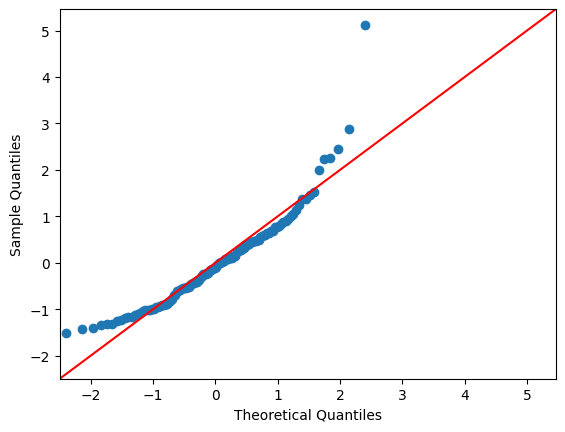

In [36]:
QQ = sm.qqplot(errors_st, line="45")


Y efectivamente, se aprecia como la mayor parte de los datos se acerca a línea recta teórica marcada en rojo que se posicionó de apoyo.

En este punto resulta prudente graficar un histograma de los residuos para ver su distribución.

### Histograma de residuos



Text(0, 0.5, 'Frecuencia')

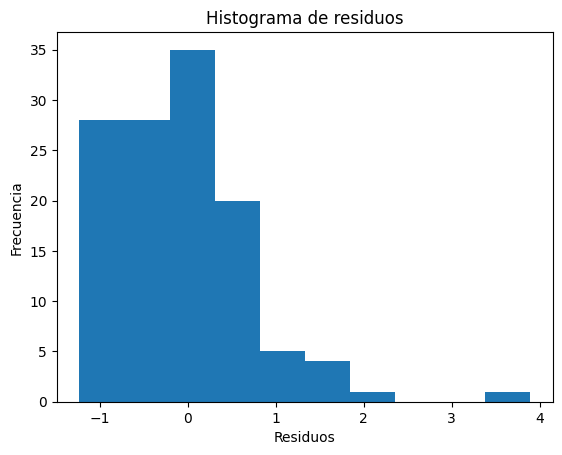

In [37]:
plt.hist(comparison_data["errors"])
plt.title("Histograma de residuos") #Residuos y herrores es lo mismo
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")

Como resultado se observa una distribución con una estructura difusamente parecida a la de una normal, pero es innegable que los errores no son completamente estocásticos, puesto que se ve una gran densidad en el lado izquierdo de la distribución.


## Resultados finales

Nos es posible determinar con una variabilidad ($R^2$) de $0.264$ el **salario en dólares americanos** de un empleado dados sus:
* $x_1$: salario
* $x_2$: si su tipo de empleo es _CT_
* $x_3$: si es de nivel _EN_
* $x_4$: si es de nivel _EX_
* $x_5$: si es de nivel _MI_

Recordar que de $x_2$ a $x_5$ se tratan de variables dicotómicas.

#### Ecuacion final

In [38]:
equation = extractCoeficientes(first_iteration_model)

<IPython.core.display.Math object>


## Conclusion

En repetidas ocasiones durante el análisis de resultados y residuos, el modelo mostró cierto grado de deficiencia, desde los valores de $R^2$, hasta el histograma de residuos.

No obstante, esto no se debe a que el modelo de regresión linear no sea el indicado para el conjunto de datos.

En lo personal se lo atribuyo más a los datos que se usaron de entrenamiento, frente a los de prueba. Probar con un conjunto de datos más grande, o intercalar los datos de entrenamiento con algún método de validación cruzada nos dotará de mayor información para mejorar el modelo.